[Course](http://deeppavlov.ai/rl_course_2020) project #6.

# Problem description

Reinforcement learning can acquire complex behaviors. When talking about reinforcement learning problem statement, it is supposed we have an environment and some agent. They communicate through actions, states and reward. States and actions are usually quite simple, and given specific agent in specific environment there's not much we can do about state or action space. As for reward, it can be defined by us. Reward design is crucial for solving the problem, but it is difficult to find some function that can  be  optimized effectively and encodes the correct task

![circle](./imgs/circle.png)

So, if we learn policy, why don't learn the reward, too?

The main idea of the [paper](https://arxiv.org/pdf/1603.00448.pdf) is to have a reward (cost function in authors terms) being defined with a neural network. Cost function and policy are learned simultaneously.

# Main Idea 

This method is called 'guided costlearning' because the  policy  optimization  “guides”  the  cost  toward good regions of the space.

"We use rich, expressive function approximators, in the form  of  neural  networks,  to  learn  cost  functions  directly on  raw  state  representations. "

Since I don't have any expert trajectories for my environments, for demo trajectories I'll use some other good algorithm result.

# Environmemt

At first we should make sure that our algorithm works on something simple and then to look at more complex environments. (Spoiler: for now it doesn't)

1. For trial runs we use CartPole: 
    4 floats as state, 2 discrete actions

2. To go deeper - Atari environments, which we later can compare to benchmarks from [here](http://htmlpreview.github.io/?https://github.com/openai/baselines/blob/master/benchmarks_atari10M.htm)

(action and states spaces, reward function) specific aspects of env if present

# Imports

In [32]:
import gym
from gym import envs
import random
import matplotlib.pyplot as plt
import torch

from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output

import gcl

%matplotlib inline

# toy env cartpole 

## General settings

In [33]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Type of self.xx: <class 'numpy.ndarray'>
Shape of self.xx: (60, 8)
Type of self.yy: <class 'numpy.ndarray'>
Shape of self.yy: (60, 1)
Kernel type: <class 'GPy.kern.src.stationary.Matern52'>
Kernel lengthscale:   index  |  Mat52.lengthscale  |  constraints  |  priors
  [0]    |         0.05000000  |      +ve      |        
  [1]    |         1.00000000  |      +ve      |        
  [2]    |         0.45000000  |      +ve      |        
  [3]    |         0.07853982  |      +ve      |        
  [4]    |         0.05000000  |      +ve      |        
  [5]    |         0.05000000  |      +ve      |        
 

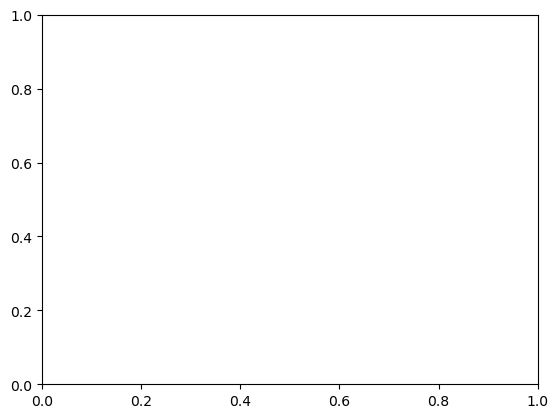

In [35]:
!pip install pandas==1.5.3
!pip install stable-baselines3
!pip install gpy
!pip install pyribbit
!pip install imageio
import gym
import numpy as np
from gym import spaces
from kitchen2d.kitchen_stuff import Kitchen2D
import active_learners.helper as helper
import kitchen2d.kitchen_stuff as ks
from kitchen2d.gripper import Gripper
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import gcl.agentVPG as gcl  # Ensure this module is correctly referenced


class KitchenEnv(gym.Env):
    def __init__(self, setting):
        super(KitchenEnv, self).__init__()
        self.setting = setting
        self.kitchen = Kitchen2D(**self.setting)
        self.gripper = None
        self.cup1 = None
        self.cup2 = None
        self.liquid = None

        self.action_space = spaces.Box(
            low=np.array([-1.0, -1.0, -np.pi]), 
            high=np.array([1.0, 1.0, np.pi]), 
            dtype=np.float32
        )

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)

        self.expid_pour = 0
        self.expid_scoop = 0
        self.objects_created = False
        self._create_objects()

        self.fig, self.ax = plt.subplots()
        self.render_initialized = False

    def reset(self, seed=None, **kwargs):
        """Reset the environment and return the initial state."""
        np.random.seed(seed)
        if not self.objects_created:
            self._create_objects()
            self.objects_created = True
        
        state = np.zeros(self.observation_space.shape, dtype=np.float32)  
        info = {}  
        return state, info

    def step(self, action):
        """Take a step in the environment based on the action."""
        dx, dy, dtheta = action  
        
        new_x = np.clip(self.gripper.position[0] + dx, -30, 30)
        new_y = np.clip(self.gripper.position[1] + dy, -10, 20)
        new_theta = np.clip(self.gripper.angle + dtheta, -np.pi, np.pi)
        self.gripper.find_path((new_x, new_y), new_theta)  
        self.gripper.release()

        grasp_successful = self.gripper.grasp(self.cup1, action[:2])

        self.render()

        if grasp_successful:
            gp_pour, c_pour = helper.process_gp_sample(self.expid_pour, exp='pour', is_adaptive=False, flag_lk=False)
            grasp, rel_x, rel_y, dangle, *_ = gp_pour.sample(c_pour)
            dangle *= np.sign(rel_x)
            pour_successful, pos_ratio = self.gripper.pour(self.cup2, (rel_x, rel_y), dangle)

            if pour_successful and pos_ratio > 0.9:
                reward = 10
                done = True
                self.gripper.place((15, 0), 0)
                self.kitchen.liquid.remove_particles_in_cup(self.cup2)
                self.kitchen.gen_liquid_in_cup(self.cup1, N=10, userData='water')
            else:
                reward = -10
                done = True
                self.kitchen.liquid.remove_particles_in_cup(self.cup2)
                self.kitchen.liquid.remove_particles_outside_cup()
                self._reset_cup1()
                self._reset_gripper()
        else:
            reward = -10
            done = True
            self.kitchen.liquid.remove_particles_in_cup(self.cup2)
            self._reset_gripper()

        self.render()
        state = np.array([
            self.gripper.position[0], self.gripper.position[1], self.gripper.angle, 
            self.cup1.position[0], self.cup1.position[1], 
            self.cup2.position[0], self.cup2.position[1], 
            len(self.kitchen.liquid.particles)
        ], dtype=np.float32)
        info = {}

        return state, reward, done, False, info

    def render(self):
        """Render the environment using matplotlib."""
        if not self.render_initialized:
            self.ax.set_xlim(-30, 30)
            self.ax.set_ylim(-10, 20)
            self.gripper_plot, = self.ax.plot([], [], "ro", label="Gripper") 
            self.cup1_plot, = self.ax.plot([], [], "yo", label="Cup1")        
            self.cup2_plot, = self.ax.plot([], [], "go", label="Cup2")        
            self.water_plot = []
            self.ax.legend()
            self.render_initialized = True

        self.gripper_plot.set_data(self.gripper.position[0], self.gripper.position[1])
        self.cup1_plot.set_data(self.cup1.position[0], self.cup1.position[1])
        self.cup2_plot.set_data(self.cup2.position[0], self.cup2.position[1])

    def _create_objects(self):
        """Create and initialize objects like gripper, cups, etc."""
        if self.cup1 is None:
            pour_from_w, pour_from_h, pour_to_w, pour_to_h = helper.process_gp_sample(self.expid_pour, exp='pour', is_adaptive=False, flag_lk=False)[1]
            holder_d = 0.5
            self.gripper = Gripper(self.kitchen, (0, 8), 0)
            self.cup1 = ks.make_cup(self.kitchen, (15, 0), 0, pour_from_w, pour_from_h, holder_d)
            self.cup2 = ks.make_cup(self.kitchen, (-25, 0), 0, pour_to_w, pour_to_h, holder_d)
            self.kitchen.gen_liquid_in_cup(self.cup1, N=10, userData='water')  

    def _reset_gripper(self):
        self.gripper.position = (0, 8)

    def _reset_cup1(self):
        self.cup1.position = (15, 0)
        self.kitchen.liquid.remove_particles_in_cup(self.cup1)
        self.kitchen.gen_liquid_in_cup(self.cup1, N=10, userData='water') 

    def close(self):
        plt.close(self.fig)


def make_env():
    setting = {
        'do_gui': False,  
        'left_table_width': 50.,
        'right_table_width': 50.,
        'planning': False,
        'overclock': 5 
    }
    return KitchenEnv(setting)


env = make_env()  
state, info = env.reset()

n_actions = env.action_space.shape[0]  
state_shape = env.observation_space.shape  


## getting demo trajectories

In [41]:
model = gcl.AgentVPG(state_shape, n_actions, 'toy')

In [42]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.9)

In [46]:
from gcl.train import train_vpg_on_session  # Correct module import

mean_rewards = []
for i in range(100):
    rewards = [train_vpg_on_session(model, env, *model.generate_session(env), optimizer)
               for _ in range(100)] 
    mean_rewards.append(np.mean(rewards))
    
    if i % 5 == 0:  # Fix condition (before it was incorrect)
        print("Mean reward: %.3f" % (np.mean(rewards)))
        plt.figure(figsize=[9, 6])
        plt.title("Mean reward per 100 games")
        plt.plot(mean_rewards)
        plt.grid()
        plt.show()
    
    if np.mean(rewards) > 500:
        print("Stopping early: reward threshold reached.")
        break


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [9]:
torch.save(model.state_dict(), 'model_vpg.pt')
#model.load_state_dict('model_vpg.pt')

In [10]:
num_demo = 500

In [11]:
demo_samples = [model.generate_session(env) for i in range(num_demo)]

## GCL training

We take cost function architecture from the paper (section 6.1). For the cartpole it might be overkill. Let's see.

We're supposed to have regularization on weights and some not straightforward thing to calculate the cost. We'll make the framework so that it could be expanded in the future, but for now we won't be doing this equation (2)

In [12]:
new_model = gcl.AgentVPG(state_shape, n_actions, 'toy')
cost = gcl.CostNN(state_shape)
optimizer_model = torch.optim.Adam(new_model.parameters(), 1e-3)
optimizer_cost = torch.optim.Adam(cost.parameters(), 1e-3)

mean reward:9.000


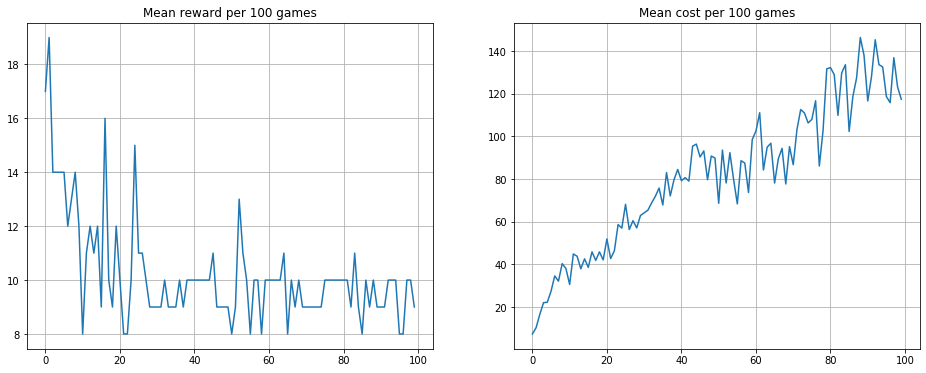

In [13]:
mean_rewards = []
mean_costs = []
size = 100
samples = [new_model.generate_session(env) for _ in range(int(size/2))]
for i in range(100):
    traj = [new_model.generate_session(env) for _ in range(int(size))]
    samples = samples + traj
    #generate samples
    demo_trajs_ids = np.random.choice(range(len(demo_samples)), size)
    demo_trajs = np.array(demo_samples)[demo_trajs_ids]
    #sampled_trajs_ids = np.random.choice(range(len(samples)), size)
    sampled_trajs = traj#np.array(samples)[sampled_trajs_ids]
    rewards, costs = [],  []
    for (demo_traj, sampled_traj) in zip(demo_trajs, sampled_trajs):
        rew, cost_item = gcl.train_gcl_on_session(
                        new_model,
                        env,
                        cost, 
                        demo_traj,
                        sampled_traj,
                        optimizer_model, 
                        optimizer_cost,
                    )
    
    rewards.append(rew)
    costs.append(cost_item)
    mean_rewards.append(np.mean(rewards))
    mean_costs.append(np.mean(costs))
    
    if i % 5:
        clear_output(True)
        print("mean reward:%.3f" % (np.mean(rewards)))
        
        plt.figure(figsize=[16, 6])
        plt.subplot(1, 2, 1)

        plt.title(f"Mean reward per {size} games")
        plt.plot(mean_rewards)
        plt.grid()

        
        plt.subplot(1, 2, 2)
        plt.title(f"Mean cost per {size} games")
        plt.plot(mean_costs)
        plt.grid()
        
        plt.show()

    
    if np.mean(rewards) > 500:
        break

# Training on Atari 

Unfortunately, my too basic knowledge of RL made it impossible to run it on Atari envs in time, despite all my attempts.  